# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

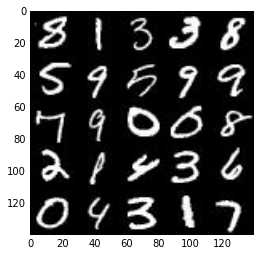

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

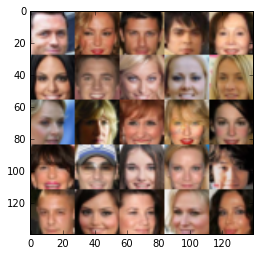

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_img = tf.placeholder(dtype=tf.float32, shape=[None, image_width, image_height, image_channels], name="input_img")
    input_z = tf.placeholder(dtype=tf.float32, shape=[None, z_dim], name="input_z")
    learning_rate = tf.placeholder(dtype=tf.float32, name="learning_rate")
    return input_img, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse=reuse):
        # image: 28*28*3
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', activation=None)
        relu1 = tf.maximum(alpha*conv1, conv1)
        # size: 14*14*64
        
        conv2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', activation=None)
        batch2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(alpha*batch2, batch2)
        # size: 7*7*128
        
        conv3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', activation=None)
        batch3 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = tf.maximum(alpha*batch3, batch3)
        # size: 4*4*256
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1, activation=None)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope("generator", reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512, activation=None)
        img1 = tf.reshape(x1, (-1,7,7,512))
        batch1 = tf.layers.batch_normalization(img1, training=is_train)
        relu1 = tf.maximum(batch1*alpha, batch1)
        # size: 7*7*512
        
        img2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=2, padding='same', activation=None)
        batch2 = tf.layers.batch_normalization(img2, training=is_train)
        relu2 = tf.maximum(batch2*alpha, batch2)
        # size: 14*14*256
        
        img3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding='same', activation=None)
        batch3 = tf.layers.batch_normalization(img3, training=is_train)
        relu3 = tf.maximum(batch3*alpha, batch3)
        # size: 28*28*128
        
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=1, padding='same', activation=None)
        out = tf.tanh(logits)
        # size: 28*28*out_channel_dim
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    d_model_real, d_logit_real = discriminator(input_real, reuse=False, alpha=alpha)
    d_model_fake, d_logit_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logit_real, labels=tf.ones_like(d_logit_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logit_fake, labels=tf.zeros_like(d_logit_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logit_fake, labels=tf.ones_like(d_logit_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [x for x in t_vars if x.name.startswith("discriminator")]
    g_vars = [x for x in t_vars if x.name.startswith("generator")]
    
    d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, alpha=0.1):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    real_image, z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(real_image, z, data_shape[3], alpha)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    step = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={real_image: batch_images, z: batch_z})
                _ = sess.run(g_opt, feed_dict={z: batch_z})
                
                if step % 10 == 0:
                    train_loss_d = d_loss.eval({real_image: batch_images, z: batch_z})
                    train_loss_g = g_loss.eval({z: batch_z})
                    
                    print("Epoch {}/{}\t".format(epoch_i, epoch_count),
                          "Discirminator Loss {:.4f}\t".format(train_loss_d),
                          "Generator Loss {:.4f}".format(train_loss_g))
                
                if step % 100 == 0:
                    show_generator_output(sess, 25, z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2	 Discirminator Loss 0.3466	 Generator Loss 6.9852
Epoch 0/2	 Discirminator Loss 0.4382	 Generator Loss 11.6898
Epoch 0/2	 Discirminator Loss 0.4333	 Generator Loss 9.1160
Epoch 0/2	 Discirminator Loss 0.3440	 Generator Loss 5.8559
Epoch 0/2	 Discirminator Loss 6.5405	 Generator Loss 0.0385
Epoch 0/2	 Discirminator Loss 0.5767	 Generator Loss 2.4273
Epoch 0/2	 Discirminator Loss 1.2386	 Generator Loss 0.8400
Epoch 0/2	 Discirminator Loss 0.7347	 Generator Loss 1.5803
Epoch 0/2	 Discirminator Loss 4.2954	 Generator Loss 0.1271
Epoch 0/2	 Discirminator Loss 1.5245	 Generator Loss 0.5092


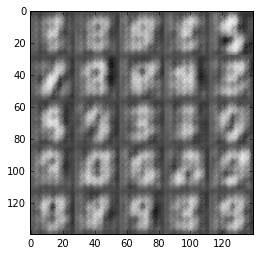

Epoch 0/2	 Discirminator Loss 1.6588	 Generator Loss 0.4511
Epoch 0/2	 Discirminator Loss 1.8719	 Generator Loss 0.3081
Epoch 0/2	 Discirminator Loss 1.6065	 Generator Loss 0.4105
Epoch 0/2	 Discirminator Loss 1.5084	 Generator Loss 0.4619
Epoch 0/2	 Discirminator Loss 1.6261	 Generator Loss 0.3861
Epoch 0/2	 Discirminator Loss 1.2765	 Generator Loss 0.7128
Epoch 0/2	 Discirminator Loss 1.8446	 Generator Loss 0.2957
Epoch 0/2	 Discirminator Loss 0.9832	 Generator Loss 0.8829
Epoch 0/2	 Discirminator Loss 1.5001	 Generator Loss 0.4511
Epoch 0/2	 Discirminator Loss 1.6017	 Generator Loss 0.4255


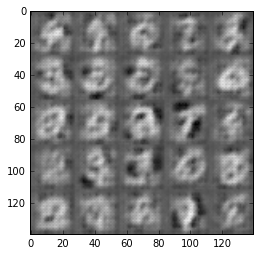

Epoch 0/2	 Discirminator Loss 1.2600	 Generator Loss 0.6674
Epoch 0/2	 Discirminator Loss 1.2895	 Generator Loss 0.6380
Epoch 0/2	 Discirminator Loss 1.6865	 Generator Loss 0.3592
Epoch 0/2	 Discirminator Loss 1.2676	 Generator Loss 1.8869
Epoch 0/2	 Discirminator Loss 1.0538	 Generator Loss 1.5027
Epoch 0/2	 Discirminator Loss 1.4165	 Generator Loss 1.4410
Epoch 0/2	 Discirminator Loss 1.3740	 Generator Loss 1.7661
Epoch 0/2	 Discirminator Loss 1.3938	 Generator Loss 1.9386
Epoch 0/2	 Discirminator Loss 1.2129	 Generator Loss 0.9716
Epoch 0/2	 Discirminator Loss 1.1361	 Generator Loss 2.1581


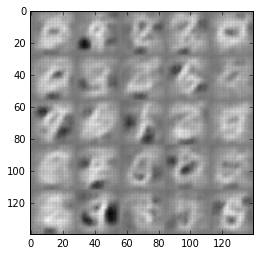

Epoch 0/2	 Discirminator Loss 1.3154	 Generator Loss 1.6881
Epoch 0/2	 Discirminator Loss 0.8590	 Generator Loss 1.1094
Epoch 0/2	 Discirminator Loss 1.1065	 Generator Loss 0.7138
Epoch 0/2	 Discirminator Loss 1.4479	 Generator Loss 0.4655
Epoch 0/2	 Discirminator Loss 1.4226	 Generator Loss 0.4822
Epoch 0/2	 Discirminator Loss 0.8589	 Generator Loss 1.0709
Epoch 0/2	 Discirminator Loss 1.2824	 Generator Loss 0.8507
Epoch 0/2	 Discirminator Loss 0.6840	 Generator Loss 2.5670
Epoch 0/2	 Discirminator Loss 1.4884	 Generator Loss 2.4278
Epoch 0/2	 Discirminator Loss 0.9041	 Generator Loss 1.5074


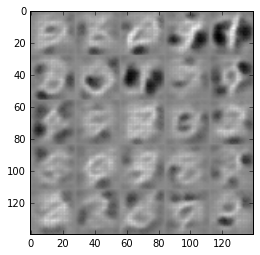

Epoch 0/2	 Discirminator Loss 1.2772	 Generator Loss 0.6342
Epoch 0/2	 Discirminator Loss 1.1453	 Generator Loss 0.7384
Epoch 0/2	 Discirminator Loss 1.1414	 Generator Loss 0.7818
Epoch 0/2	 Discirminator Loss 1.2342	 Generator Loss 0.6896
Epoch 0/2	 Discirminator Loss 1.3164	 Generator Loss 0.5974
Epoch 0/2	 Discirminator Loss 1.5242	 Generator Loss 0.4293
Epoch 0/2	 Discirminator Loss 1.2015	 Generator Loss 0.6899
Epoch 0/2	 Discirminator Loss 1.4268	 Generator Loss 0.5365
Epoch 0/2	 Discirminator Loss 1.1135	 Generator Loss 1.0738
Epoch 0/2	 Discirminator Loss 1.2362	 Generator Loss 0.9150


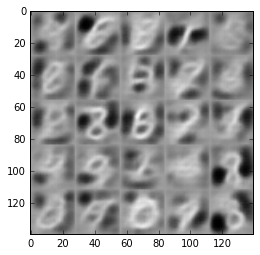

Epoch 0/2	 Discirminator Loss 1.1668	 Generator Loss 0.8897
Epoch 0/2	 Discirminator Loss 1.2534	 Generator Loss 0.9356
Epoch 0/2	 Discirminator Loss 1.3598	 Generator Loss 1.4321
Epoch 0/2	 Discirminator Loss 1.1594	 Generator Loss 0.8578
Epoch 0/2	 Discirminator Loss 1.2522	 Generator Loss 1.2247
Epoch 0/2	 Discirminator Loss 1.1094	 Generator Loss 1.2913
Epoch 0/2	 Discirminator Loss 1.4224	 Generator Loss 0.4873
Epoch 0/2	 Discirminator Loss 1.6888	 Generator Loss 0.3567
Epoch 0/2	 Discirminator Loss 1.2776	 Generator Loss 0.6552
Epoch 0/2	 Discirminator Loss 1.3696	 Generator Loss 0.5568


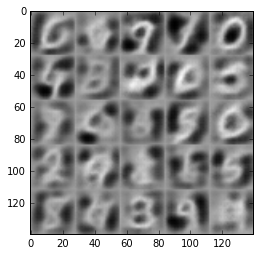

Epoch 0/2	 Discirminator Loss 1.5934	 Generator Loss 0.3785
Epoch 0/2	 Discirminator Loss 1.2966	 Generator Loss 0.6453
Epoch 0/2	 Discirminator Loss 1.5415	 Generator Loss 2.0340
Epoch 0/2	 Discirminator Loss 1.2895	 Generator Loss 0.7213
Epoch 0/2	 Discirminator Loss 1.5151	 Generator Loss 0.4357
Epoch 0/2	 Discirminator Loss 1.6011	 Generator Loss 0.3831
Epoch 0/2	 Discirminator Loss 1.1567	 Generator Loss 0.9695
Epoch 0/2	 Discirminator Loss 1.3140	 Generator Loss 1.4540
Epoch 0/2	 Discirminator Loss 1.2913	 Generator Loss 0.6944
Epoch 0/2	 Discirminator Loss 1.4177	 Generator Loss 0.5448


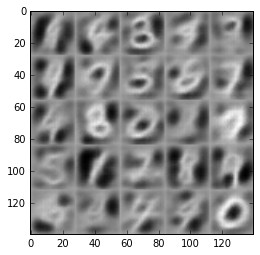

Epoch 0/2	 Discirminator Loss 1.5681	 Generator Loss 0.4086
Epoch 0/2	 Discirminator Loss 1.1806	 Generator Loss 0.6686
Epoch 0/2	 Discirminator Loss 1.9527	 Generator Loss 0.2475
Epoch 0/2	 Discirminator Loss 1.2236	 Generator Loss 0.6803
Epoch 0/2	 Discirminator Loss 1.1212	 Generator Loss 0.8884
Epoch 0/2	 Discirminator Loss 1.5104	 Generator Loss 0.4343
Epoch 0/2	 Discirminator Loss 2.2198	 Generator Loss 0.2086
Epoch 0/2	 Discirminator Loss 1.2877	 Generator Loss 0.7270
Epoch 0/2	 Discirminator Loss 1.1510	 Generator Loss 0.8209
Epoch 0/2	 Discirminator Loss 1.3772	 Generator Loss 1.5435


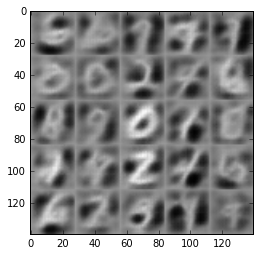

Epoch 0/2	 Discirminator Loss 1.1937	 Generator Loss 0.9313
Epoch 0/2	 Discirminator Loss 1.4159	 Generator Loss 1.5556
Epoch 0/2	 Discirminator Loss 1.2320	 Generator Loss 0.6303
Epoch 0/2	 Discirminator Loss 1.3136	 Generator Loss 0.5499
Epoch 0/2	 Discirminator Loss 1.7711	 Generator Loss 0.3233
Epoch 0/2	 Discirminator Loss 1.3281	 Generator Loss 0.5884
Epoch 0/2	 Discirminator Loss 1.2958	 Generator Loss 0.5732
Epoch 0/2	 Discirminator Loss 1.5612	 Generator Loss 0.4173
Epoch 0/2	 Discirminator Loss 1.2846	 Generator Loss 0.6265
Epoch 0/2	 Discirminator Loss 1.1547	 Generator Loss 1.1599


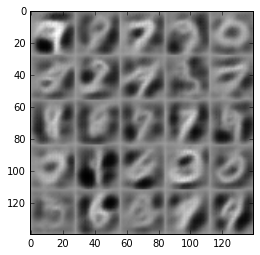

Epoch 0/2	 Discirminator Loss 1.1164	 Generator Loss 1.0436
Epoch 0/2	 Discirminator Loss 1.4177	 Generator Loss 0.4737
Epoch 0/2	 Discirminator Loss 1.4586	 Generator Loss 0.5046
Epoch 1/2	 Discirminator Loss 1.3909	 Generator Loss 0.5950
Epoch 1/2	 Discirminator Loss 1.2307	 Generator Loss 0.9784
Epoch 1/2	 Discirminator Loss 1.1953	 Generator Loss 0.6431
Epoch 1/2	 Discirminator Loss 1.2886	 Generator Loss 0.6176
Epoch 1/2	 Discirminator Loss 1.3358	 Generator Loss 0.5698
Epoch 1/2	 Discirminator Loss 2.7939	 Generator Loss 0.1194
Epoch 1/2	 Discirminator Loss 1.1925	 Generator Loss 0.7371


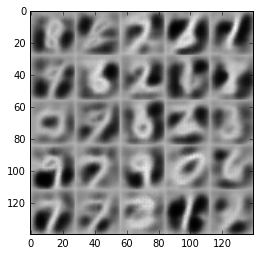

Epoch 1/2	 Discirminator Loss 1.2061	 Generator Loss 0.7127
Epoch 1/2	 Discirminator Loss 1.1567	 Generator Loss 0.7365
Epoch 1/2	 Discirminator Loss 1.3828	 Generator Loss 0.5252
Epoch 1/2	 Discirminator Loss 1.6958	 Generator Loss 0.3496
Epoch 1/2	 Discirminator Loss 1.2462	 Generator Loss 0.6493
Epoch 1/2	 Discirminator Loss 1.1040	 Generator Loss 0.8743
Epoch 1/2	 Discirminator Loss 1.1457	 Generator Loss 0.7986
Epoch 1/2	 Discirminator Loss 1.4639	 Generator Loss 0.4622
Epoch 1/2	 Discirminator Loss 1.4168	 Generator Loss 0.4688
Epoch 1/2	 Discirminator Loss 1.1903	 Generator Loss 0.8324


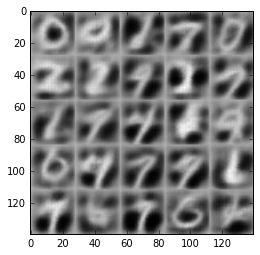

Epoch 1/2	 Discirminator Loss 1.2181	 Generator Loss 1.8232
Epoch 1/2	 Discirminator Loss 1.0254	 Generator Loss 1.9582
Epoch 1/2	 Discirminator Loss 1.1082	 Generator Loss 1.0073
Epoch 1/2	 Discirminator Loss 0.9461	 Generator Loss 1.2219
Epoch 1/2	 Discirminator Loss 1.7127	 Generator Loss 2.4605
Epoch 1/2	 Discirminator Loss 1.2304	 Generator Loss 0.6701
Epoch 1/2	 Discirminator Loss 1.0854	 Generator Loss 0.9797
Epoch 1/2	 Discirminator Loss 1.0055	 Generator Loss 0.9883
Epoch 1/2	 Discirminator Loss 1.1859	 Generator Loss 0.6715
Epoch 1/2	 Discirminator Loss 1.2411	 Generator Loss 0.6489


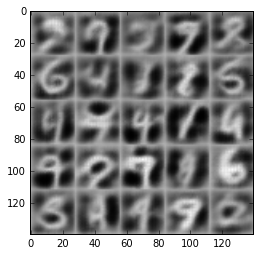

Epoch 1/2	 Discirminator Loss 1.1569	 Generator Loss 1.3351
Epoch 1/2	 Discirminator Loss 1.0143	 Generator Loss 1.0389
Epoch 1/2	 Discirminator Loss 1.2837	 Generator Loss 1.6003
Epoch 1/2	 Discirminator Loss 1.1992	 Generator Loss 0.9245
Epoch 1/2	 Discirminator Loss 1.0438	 Generator Loss 0.8911
Epoch 1/2	 Discirminator Loss 1.0822	 Generator Loss 1.3473
Epoch 1/2	 Discirminator Loss 0.9859	 Generator Loss 1.1377
Epoch 1/2	 Discirminator Loss 0.9343	 Generator Loss 1.0711
Epoch 1/2	 Discirminator Loss 0.9882	 Generator Loss 1.4706
Epoch 1/2	 Discirminator Loss 1.3734	 Generator Loss 1.7243


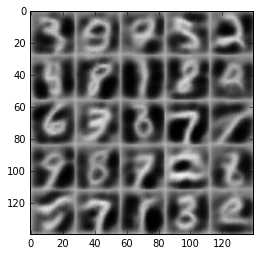

Epoch 1/2	 Discirminator Loss 1.3406	 Generator Loss 0.5769
Epoch 1/2	 Discirminator Loss 1.1248	 Generator Loss 0.7923
Epoch 1/2	 Discirminator Loss 1.4310	 Generator Loss 0.4870
Epoch 1/2	 Discirminator Loss 0.8906	 Generator Loss 1.3012
Epoch 1/2	 Discirminator Loss 1.0202	 Generator Loss 1.4855
Epoch 1/2	 Discirminator Loss 1.4590	 Generator Loss 0.4799
Epoch 1/2	 Discirminator Loss 1.1991	 Generator Loss 0.7842
Epoch 1/2	 Discirminator Loss 1.3569	 Generator Loss 0.5700
Epoch 1/2	 Discirminator Loss 1.7481	 Generator Loss 0.3335
Epoch 1/2	 Discirminator Loss 0.9783	 Generator Loss 1.1851


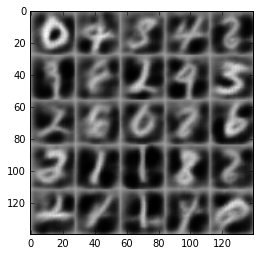

Epoch 1/2	 Discirminator Loss 0.9060	 Generator Loss 1.8166
Epoch 1/2	 Discirminator Loss 0.9971	 Generator Loss 1.2857
Epoch 1/2	 Discirminator Loss 1.1560	 Generator Loss 0.7096
Epoch 1/2	 Discirminator Loss 1.6608	 Generator Loss 0.3930
Epoch 1/2	 Discirminator Loss 1.0753	 Generator Loss 0.9272
Epoch 1/2	 Discirminator Loss 1.2680	 Generator Loss 2.7394
Epoch 1/2	 Discirminator Loss 1.0894	 Generator Loss 0.8328
Epoch 1/2	 Discirminator Loss 1.6342	 Generator Loss 0.3683
Epoch 1/2	 Discirminator Loss 1.2474	 Generator Loss 0.6014
Epoch 1/2	 Discirminator Loss 1.0559	 Generator Loss 0.8252


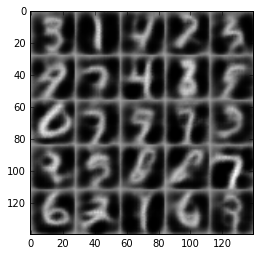

Epoch 1/2	 Discirminator Loss 1.1524	 Generator Loss 0.7165
Epoch 1/2	 Discirminator Loss 1.5229	 Generator Loss 0.4109
Epoch 1/2	 Discirminator Loss 1.3919	 Generator Loss 0.5285
Epoch 1/2	 Discirminator Loss 0.8410	 Generator Loss 1.3365
Epoch 1/2	 Discirminator Loss 1.0401	 Generator Loss 1.0952
Epoch 1/2	 Discirminator Loss 0.9390	 Generator Loss 1.4993
Epoch 1/2	 Discirminator Loss 1.0009	 Generator Loss 1.6116
Epoch 1/2	 Discirminator Loss 1.0666	 Generator Loss 1.2844
Epoch 1/2	 Discirminator Loss 0.8815	 Generator Loss 1.5431
Epoch 1/2	 Discirminator Loss 0.9727	 Generator Loss 0.9588


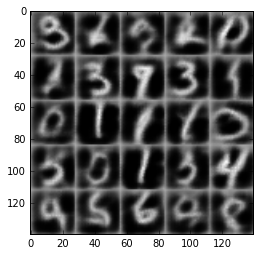

Epoch 1/2	 Discirminator Loss 1.3485	 Generator Loss 1.7657
Epoch 1/2	 Discirminator Loss 1.0724	 Generator Loss 1.0150
Epoch 1/2	 Discirminator Loss 1.3357	 Generator Loss 0.5297
Epoch 1/2	 Discirminator Loss 1.0589	 Generator Loss 0.8318
Epoch 1/2	 Discirminator Loss 1.5610	 Generator Loss 0.4665
Epoch 1/2	 Discirminator Loss 1.1137	 Generator Loss 0.7209
Epoch 1/2	 Discirminator Loss 1.3057	 Generator Loss 0.5775
Epoch 1/2	 Discirminator Loss 1.3422	 Generator Loss 0.6192
Epoch 1/2	 Discirminator Loss 0.7951	 Generator Loss 1.4858
Epoch 1/2	 Discirminator Loss 1.0622	 Generator Loss 1.5607


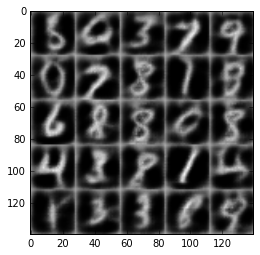

Epoch 1/2	 Discirminator Loss 0.8595	 Generator Loss 1.5065
Epoch 1/2	 Discirminator Loss 1.4242	 Generator Loss 1.9170
Epoch 1/2	 Discirminator Loss 1.1693	 Generator Loss 0.9024
Epoch 1/2	 Discirminator Loss 1.4224	 Generator Loss 0.5574
Epoch 1/2	 Discirminator Loss 1.0310	 Generator Loss 0.8008
Epoch 1/2	 Discirminator Loss 1.1069	 Generator Loss 0.7387
Epoch 1/2	 Discirminator Loss 1.0951	 Generator Loss 0.7795
Epoch 1/2	 Discirminator Loss 1.4815	 Generator Loss 0.4686
Epoch 1/2	 Discirminator Loss 1.0160	 Generator Loss 0.8741
Epoch 1/2	 Discirminator Loss 1.2261	 Generator Loss 0.6711


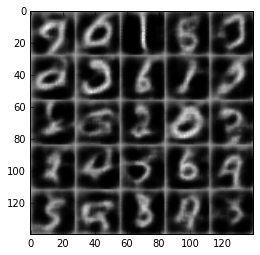

Epoch 1/2	 Discirminator Loss 1.1274	 Generator Loss 1.9695
Epoch 1/2	 Discirminator Loss 1.0898	 Generator Loss 1.7472
Epoch 1/2	 Discirminator Loss 0.8756	 Generator Loss 1.1191
Epoch 1/2	 Discirminator Loss 0.7183	 Generator Loss 1.5284
Epoch 1/2	 Discirminator Loss 2.1262	 Generator Loss 0.2367
Epoch 1/2	 Discirminator Loss 1.4354	 Generator Loss 0.5285
Epoch 1/2	 Discirminator Loss 1.4667	 Generator Loss 0.4852


In [22]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.2
alpha = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, alpha)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1	 Discirminator Loss 0.6153	 Generator Loss 21.6046
Epoch 0/1	 Discirminator Loss 0.6005	 Generator Loss 13.6664
Epoch 0/1	 Discirminator Loss 0.8413	 Generator Loss 2.0014
Epoch 0/1	 Discirminator Loss 0.7442	 Generator Loss 2.9099
Epoch 0/1	 Discirminator Loss 1.5890	 Generator Loss 4.7785
Epoch 0/1	 Discirminator Loss 0.5730	 Generator Loss 2.7228
Epoch 0/1	 Discirminator Loss 0.7833	 Generator Loss 2.9151
Epoch 0/1	 Discirminator Loss 0.5282	 Generator Loss 2.8114
Epoch 0/1	 Discirminator Loss 0.8830	 Generator Loss 1.2921
Epoch 0/1	 Discirminator Loss 2.7146	 Generator Loss 6.4893


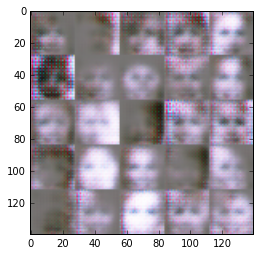

Epoch 0/1	 Discirminator Loss 0.6659	 Generator Loss 1.7972
Epoch 0/1	 Discirminator Loss 0.8092	 Generator Loss 1.4861
Epoch 0/1	 Discirminator Loss 1.4738	 Generator Loss 1.7908
Epoch 0/1	 Discirminator Loss 1.3704	 Generator Loss 1.4831
Epoch 0/1	 Discirminator Loss 1.4340	 Generator Loss 1.0128
Epoch 0/1	 Discirminator Loss 1.4095	 Generator Loss 2.1321
Epoch 0/1	 Discirminator Loss 1.2306	 Generator Loss 0.7168
Epoch 0/1	 Discirminator Loss 1.4054	 Generator Loss 0.6110
Epoch 0/1	 Discirminator Loss 1.4309	 Generator Loss 0.7663
Epoch 0/1	 Discirminator Loss 1.4710	 Generator Loss 0.5790


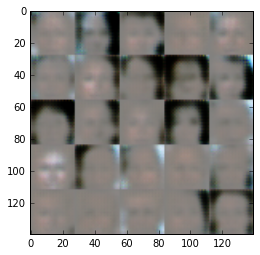

Epoch 0/1	 Discirminator Loss 1.3154	 Generator Loss 0.5361
Epoch 0/1	 Discirminator Loss 1.3892	 Generator Loss 0.8631
Epoch 0/1	 Discirminator Loss 1.2891	 Generator Loss 0.6554
Epoch 0/1	 Discirminator Loss 1.3059	 Generator Loss 0.7871
Epoch 0/1	 Discirminator Loss 1.3170	 Generator Loss 0.6776
Epoch 0/1	 Discirminator Loss 1.3646	 Generator Loss 0.9457
Epoch 0/1	 Discirminator Loss 1.3322	 Generator Loss 0.9506
Epoch 0/1	 Discirminator Loss 1.5368	 Generator Loss 1.9877
Epoch 0/1	 Discirminator Loss 1.3398	 Generator Loss 0.7028
Epoch 0/1	 Discirminator Loss 1.2469	 Generator Loss 0.8730


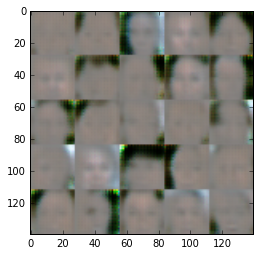

Epoch 0/1	 Discirminator Loss 1.4675	 Generator Loss 1.5701
Epoch 0/1	 Discirminator Loss 1.2865	 Generator Loss 0.6531
Epoch 0/1	 Discirminator Loss 1.3481	 Generator Loss 0.9430
Epoch 0/1	 Discirminator Loss 1.1083	 Generator Loss 0.8525
Epoch 0/1	 Discirminator Loss 1.0839	 Generator Loss 0.9515
Epoch 0/1	 Discirminator Loss 1.3526	 Generator Loss 0.7062
Epoch 0/1	 Discirminator Loss 1.2939	 Generator Loss 0.7163
Epoch 0/1	 Discirminator Loss 1.2910	 Generator Loss 0.9347
Epoch 0/1	 Discirminator Loss 1.1074	 Generator Loss 0.9869
Epoch 0/1	 Discirminator Loss 1.5311	 Generator Loss 0.4572


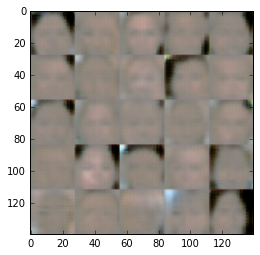

Epoch 0/1	 Discirminator Loss 1.2722	 Generator Loss 0.6594
Epoch 0/1	 Discirminator Loss 1.2535	 Generator Loss 1.8478
Epoch 0/1	 Discirminator Loss 1.7874	 Generator Loss 0.2962
Epoch 0/1	 Discirminator Loss 1.4379	 Generator Loss 1.9407
Epoch 0/1	 Discirminator Loss 1.4494	 Generator Loss 0.7975
Epoch 0/1	 Discirminator Loss 1.3462	 Generator Loss 0.8821
Epoch 0/1	 Discirminator Loss 1.1600	 Generator Loss 0.8628
Epoch 0/1	 Discirminator Loss 1.4763	 Generator Loss 0.6035
Epoch 0/1	 Discirminator Loss 1.4419	 Generator Loss 0.4441
Epoch 0/1	 Discirminator Loss 1.3885	 Generator Loss 0.5667


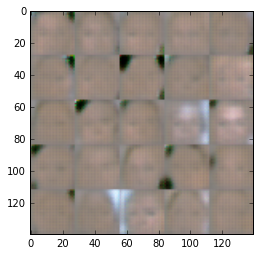

Epoch 0/1	 Discirminator Loss 1.2967	 Generator Loss 1.3099
Epoch 0/1	 Discirminator Loss 1.3911	 Generator Loss 0.5985
Epoch 0/1	 Discirminator Loss 1.1696	 Generator Loss 0.7518
Epoch 0/1	 Discirminator Loss 1.2522	 Generator Loss 0.8660
Epoch 0/1	 Discirminator Loss 1.4126	 Generator Loss 0.6120
Epoch 0/1	 Discirminator Loss 1.4612	 Generator Loss 1.5431
Epoch 0/1	 Discirminator Loss 1.5004	 Generator Loss 1.9345
Epoch 0/1	 Discirminator Loss 1.6161	 Generator Loss 1.8612
Epoch 0/1	 Discirminator Loss 1.1211	 Generator Loss 0.7835
Epoch 0/1	 Discirminator Loss 1.2555	 Generator Loss 0.6439


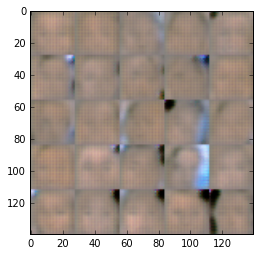

Epoch 0/1	 Discirminator Loss 1.3734	 Generator Loss 0.5175
Epoch 0/1	 Discirminator Loss 1.3352	 Generator Loss 1.4282
Epoch 0/1	 Discirminator Loss 1.4770	 Generator Loss 0.8915
Epoch 0/1	 Discirminator Loss 0.7744	 Generator Loss 1.2769
Epoch 0/1	 Discirminator Loss 1.7363	 Generator Loss 0.4634
Epoch 0/1	 Discirminator Loss 1.3888	 Generator Loss 0.5156
Epoch 0/1	 Discirminator Loss 1.3006	 Generator Loss 1.0272
Epoch 0/1	 Discirminator Loss 1.5457	 Generator Loss 0.4544
Epoch 0/1	 Discirminator Loss 1.3709	 Generator Loss 1.3117
Epoch 0/1	 Discirminator Loss 1.2128	 Generator Loss 1.1764


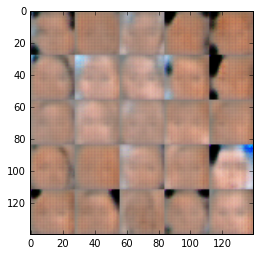

Epoch 0/1	 Discirminator Loss 1.3480	 Generator Loss 0.8399
Epoch 0/1	 Discirminator Loss 1.1632	 Generator Loss 0.6830
Epoch 0/1	 Discirminator Loss 1.2971	 Generator Loss 1.0894
Epoch 0/1	 Discirminator Loss 1.3041	 Generator Loss 0.8854
Epoch 0/1	 Discirminator Loss 1.3449	 Generator Loss 0.7548
Epoch 0/1	 Discirminator Loss 1.4974	 Generator Loss 0.4742
Epoch 0/1	 Discirminator Loss 1.2236	 Generator Loss 0.9177
Epoch 0/1	 Discirminator Loss 1.2332	 Generator Loss 0.8107
Epoch 0/1	 Discirminator Loss 0.9794	 Generator Loss 1.0297
Epoch 0/1	 Discirminator Loss 1.2084	 Generator Loss 0.8507


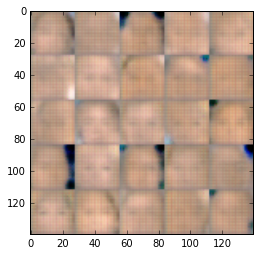

Epoch 0/1	 Discirminator Loss 1.6574	 Generator Loss 0.3555
Epoch 0/1	 Discirminator Loss 1.2567	 Generator Loss 0.7776
Epoch 0/1	 Discirminator Loss 1.1712	 Generator Loss 0.8727
Epoch 0/1	 Discirminator Loss 1.2894	 Generator Loss 0.9632
Epoch 0/1	 Discirminator Loss 1.2553	 Generator Loss 0.7592
Epoch 0/1	 Discirminator Loss 1.2055	 Generator Loss 0.7548
Epoch 0/1	 Discirminator Loss 1.2038	 Generator Loss 0.8400
Epoch 0/1	 Discirminator Loss 1.2843	 Generator Loss 0.7033
Epoch 0/1	 Discirminator Loss 1.2708	 Generator Loss 0.5652
Epoch 0/1	 Discirminator Loss 1.3687	 Generator Loss 0.5359


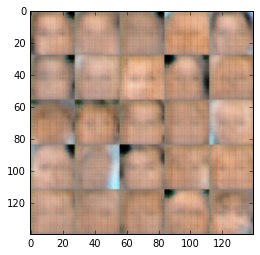

Epoch 0/1	 Discirminator Loss 0.8351	 Generator Loss 1.3080
Epoch 0/1	 Discirminator Loss 1.2299	 Generator Loss 0.8962
Epoch 0/1	 Discirminator Loss 1.3252	 Generator Loss 0.8542
Epoch 0/1	 Discirminator Loss 1.1104	 Generator Loss 0.8309
Epoch 0/1	 Discirminator Loss 1.2897	 Generator Loss 0.9338
Epoch 0/1	 Discirminator Loss 1.3712	 Generator Loss 0.5343
Epoch 0/1	 Discirminator Loss 1.5237	 Generator Loss 0.4128
Epoch 0/1	 Discirminator Loss 1.2725	 Generator Loss 0.7351
Epoch 0/1	 Discirminator Loss 1.9322	 Generator Loss 0.2942
Epoch 0/1	 Discirminator Loss 1.3366	 Generator Loss 1.1023


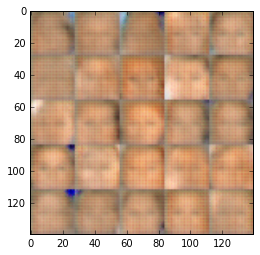

Epoch 0/1	 Discirminator Loss 1.3631	 Generator Loss 0.8183
Epoch 0/1	 Discirminator Loss 1.3420	 Generator Loss 0.7808
Epoch 0/1	 Discirminator Loss 1.3362	 Generator Loss 0.6090
Epoch 0/1	 Discirminator Loss 1.3136	 Generator Loss 0.5557
Epoch 0/1	 Discirminator Loss 1.3916	 Generator Loss 1.0220
Epoch 0/1	 Discirminator Loss 1.3012	 Generator Loss 0.7392
Epoch 0/1	 Discirminator Loss 1.3228	 Generator Loss 0.8465
Epoch 0/1	 Discirminator Loss 1.3231	 Generator Loss 1.1147
Epoch 0/1	 Discirminator Loss 1.0927	 Generator Loss 1.0714
Epoch 0/1	 Discirminator Loss 1.2608	 Generator Loss 0.6378


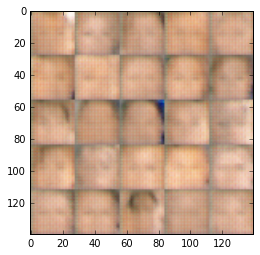

Epoch 0/1	 Discirminator Loss 1.1929	 Generator Loss 0.6947
Epoch 0/1	 Discirminator Loss 1.5123	 Generator Loss 1.2287
Epoch 0/1	 Discirminator Loss 1.3473	 Generator Loss 0.7341
Epoch 0/1	 Discirminator Loss 1.2270	 Generator Loss 0.8024
Epoch 0/1	 Discirminator Loss 1.4590	 Generator Loss 0.7848
Epoch 0/1	 Discirminator Loss 2.0984	 Generator Loss 0.2678
Epoch 0/1	 Discirminator Loss 1.4016	 Generator Loss 0.7952
Epoch 0/1	 Discirminator Loss 1.2971	 Generator Loss 0.8006
Epoch 0/1	 Discirminator Loss 1.3371	 Generator Loss 0.6257
Epoch 0/1	 Discirminator Loss 1.2820	 Generator Loss 0.9507


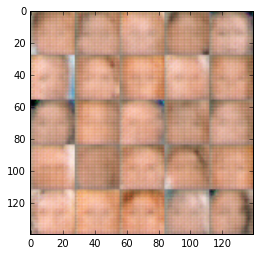

Epoch 0/1	 Discirminator Loss 1.3621	 Generator Loss 0.5169
Epoch 0/1	 Discirminator Loss 1.2711	 Generator Loss 0.8515
Epoch 0/1	 Discirminator Loss 1.3099	 Generator Loss 1.0340
Epoch 0/1	 Discirminator Loss 1.2956	 Generator Loss 0.9709
Epoch 0/1	 Discirminator Loss 1.3400	 Generator Loss 0.8077
Epoch 0/1	 Discirminator Loss 1.2801	 Generator Loss 1.0267
Epoch 0/1	 Discirminator Loss 1.4686	 Generator Loss 0.4516
Epoch 0/1	 Discirminator Loss 1.2683	 Generator Loss 0.8198
Epoch 0/1	 Discirminator Loss 1.3214	 Generator Loss 0.9077
Epoch 0/1	 Discirminator Loss 1.2865	 Generator Loss 0.8313


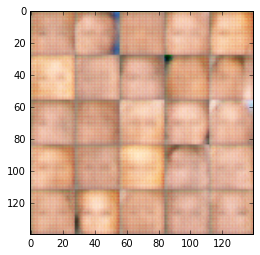

Epoch 0/1	 Discirminator Loss 1.3697	 Generator Loss 1.2619
Epoch 0/1	 Discirminator Loss 1.3360	 Generator Loss 0.8301
Epoch 0/1	 Discirminator Loss 1.2214	 Generator Loss 0.7901
Epoch 0/1	 Discirminator Loss 1.4418	 Generator Loss 1.0864
Epoch 0/1	 Discirminator Loss 1.3279	 Generator Loss 0.8291
Epoch 0/1	 Discirminator Loss 1.3710	 Generator Loss 0.5660
Epoch 0/1	 Discirminator Loss 1.2994	 Generator Loss 0.9984
Epoch 0/1	 Discirminator Loss 1.2622	 Generator Loss 0.8902
Epoch 0/1	 Discirminator Loss 1.2974	 Generator Loss 0.7517
Epoch 0/1	 Discirminator Loss 1.4843	 Generator Loss 0.4667


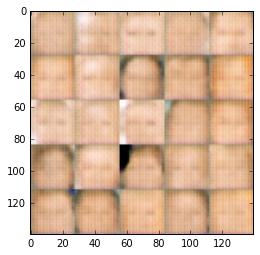

Epoch 0/1	 Discirminator Loss 1.3291	 Generator Loss 0.9815
Epoch 0/1	 Discirminator Loss 1.3026	 Generator Loss 0.7678
Epoch 0/1	 Discirminator Loss 1.6884	 Generator Loss 1.3574
Epoch 0/1	 Discirminator Loss 1.2829	 Generator Loss 0.5757
Epoch 0/1	 Discirminator Loss 1.1962	 Generator Loss 1.1902
Epoch 0/1	 Discirminator Loss 1.2742	 Generator Loss 0.9162
Epoch 0/1	 Discirminator Loss 1.3024	 Generator Loss 0.8729
Epoch 0/1	 Discirminator Loss 1.4032	 Generator Loss 0.8697
Epoch 0/1	 Discirminator Loss 1.2657	 Generator Loss 0.6729
Epoch 0/1	 Discirminator Loss 1.3664	 Generator Loss 0.7581


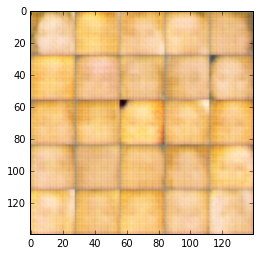

Epoch 0/1	 Discirminator Loss 1.3149	 Generator Loss 0.7711
Epoch 0/1	 Discirminator Loss 1.3625	 Generator Loss 1.1152
Epoch 0/1	 Discirminator Loss 1.2324	 Generator Loss 0.8891
Epoch 0/1	 Discirminator Loss 1.3358	 Generator Loss 1.6196
Epoch 0/1	 Discirminator Loss 1.1778	 Generator Loss 1.0352
Epoch 0/1	 Discirminator Loss 1.1573	 Generator Loss 1.3922
Epoch 0/1	 Discirminator Loss 1.1189	 Generator Loss 0.9891
Epoch 0/1	 Discirminator Loss 1.3708	 Generator Loss 0.5535
Epoch 0/1	 Discirminator Loss 1.1100	 Generator Loss 0.7629
Epoch 0/1	 Discirminator Loss 1.4236	 Generator Loss 0.5579


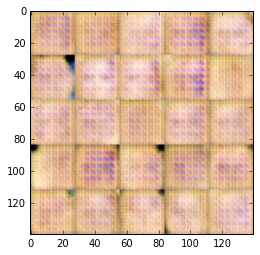

Epoch 0/1	 Discirminator Loss 1.2582	 Generator Loss 0.5851
Epoch 0/1	 Discirminator Loss 1.2081	 Generator Loss 1.1044
Epoch 0/1	 Discirminator Loss 1.2484	 Generator Loss 1.2056
Epoch 0/1	 Discirminator Loss 1.2810	 Generator Loss 1.1713
Epoch 0/1	 Discirminator Loss 1.2668	 Generator Loss 1.1212
Epoch 0/1	 Discirminator Loss 1.3678	 Generator Loss 1.1836
Epoch 0/1	 Discirminator Loss 1.2060	 Generator Loss 0.8811
Epoch 0/1	 Discirminator Loss 1.4173	 Generator Loss 0.5696
Epoch 0/1	 Discirminator Loss 1.2929	 Generator Loss 0.8347
Epoch 0/1	 Discirminator Loss 1.1793	 Generator Loss 1.3392


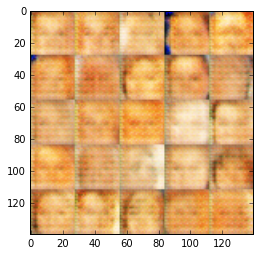

Epoch 0/1	 Discirminator Loss 1.3043	 Generator Loss 0.8247
Epoch 0/1	 Discirminator Loss 1.3666	 Generator Loss 0.7192
Epoch 0/1	 Discirminator Loss 1.3238	 Generator Loss 0.8448
Epoch 0/1	 Discirminator Loss 1.2842	 Generator Loss 0.8099
Epoch 0/1	 Discirminator Loss 1.4106	 Generator Loss 1.7402
Epoch 0/1	 Discirminator Loss 1.0838	 Generator Loss 0.6693
Epoch 0/1	 Discirminator Loss 1.4436	 Generator Loss 0.7107
Epoch 0/1	 Discirminator Loss 1.3212	 Generator Loss 0.9856
Epoch 0/1	 Discirminator Loss 1.1491	 Generator Loss 1.3672
Epoch 0/1	 Discirminator Loss 1.3656	 Generator Loss 0.7482


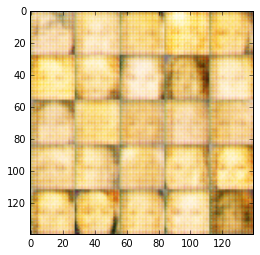

Epoch 0/1	 Discirminator Loss 1.2342	 Generator Loss 1.2712
Epoch 0/1	 Discirminator Loss 1.3605	 Generator Loss 0.5435
Epoch 0/1	 Discirminator Loss 1.4617	 Generator Loss 0.7495
Epoch 0/1	 Discirminator Loss 1.3546	 Generator Loss 0.9096
Epoch 0/1	 Discirminator Loss 1.4690	 Generator Loss 0.5085
Epoch 0/1	 Discirminator Loss 1.3681	 Generator Loss 0.8465
Epoch 0/1	 Discirminator Loss 1.2993	 Generator Loss 0.8957
Epoch 0/1	 Discirminator Loss 1.3073	 Generator Loss 0.7368
Epoch 0/1	 Discirminator Loss 1.3641	 Generator Loss 0.9619
Epoch 0/1	 Discirminator Loss 1.3335	 Generator Loss 0.9591


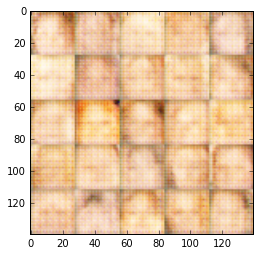

Epoch 0/1	 Discirminator Loss 1.3848	 Generator Loss 0.8497
Epoch 0/1	 Discirminator Loss 1.3500	 Generator Loss 0.9878
Epoch 0/1	 Discirminator Loss 1.3116	 Generator Loss 0.7149
Epoch 0/1	 Discirminator Loss 1.3330	 Generator Loss 0.7099
Epoch 0/1	 Discirminator Loss 1.5475	 Generator Loss 0.4083
Epoch 0/1	 Discirminator Loss 1.3029	 Generator Loss 0.6399
Epoch 0/1	 Discirminator Loss 1.2758	 Generator Loss 0.8196
Epoch 0/1	 Discirminator Loss 1.4050	 Generator Loss 0.7414
Epoch 0/1	 Discirminator Loss 1.2267	 Generator Loss 0.9894
Epoch 0/1	 Discirminator Loss 1.2858	 Generator Loss 0.7476


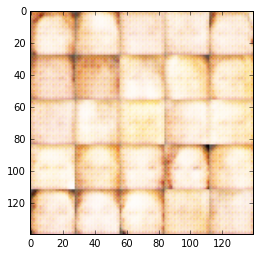

Epoch 0/1	 Discirminator Loss 1.2893	 Generator Loss 0.6867
Epoch 0/1	 Discirminator Loss 1.1513	 Generator Loss 1.9018
Epoch 0/1	 Discirminator Loss 1.3373	 Generator Loss 1.0511
Epoch 0/1	 Discirminator Loss 1.2750	 Generator Loss 0.7633
Epoch 0/1	 Discirminator Loss 1.2765	 Generator Loss 0.7199
Epoch 0/1	 Discirminator Loss 1.3223	 Generator Loss 1.0192
Epoch 0/1	 Discirminator Loss 1.4053	 Generator Loss 0.6915
Epoch 0/1	 Discirminator Loss 1.6939	 Generator Loss 0.3826
Epoch 0/1	 Discirminator Loss 1.3793	 Generator Loss 0.7861
Epoch 0/1	 Discirminator Loss 1.2864	 Generator Loss 0.8767


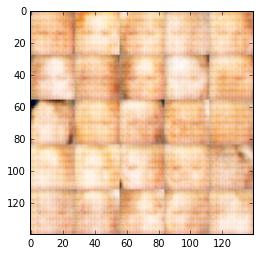

Epoch 0/1	 Discirminator Loss 1.3618	 Generator Loss 0.6946
Epoch 0/1	 Discirminator Loss 1.3651	 Generator Loss 0.8501
Epoch 0/1	 Discirminator Loss 1.3523	 Generator Loss 0.8230
Epoch 0/1	 Discirminator Loss 1.2357	 Generator Loss 0.9805
Epoch 0/1	 Discirminator Loss 1.2938	 Generator Loss 1.1510
Epoch 0/1	 Discirminator Loss 1.6157	 Generator Loss 0.5220
Epoch 0/1	 Discirminator Loss 1.6195	 Generator Loss 0.5280
Epoch 0/1	 Discirminator Loss 1.3147	 Generator Loss 0.8215
Epoch 0/1	 Discirminator Loss 1.2588	 Generator Loss 0.6506
Epoch 0/1	 Discirminator Loss 1.2996	 Generator Loss 0.7338


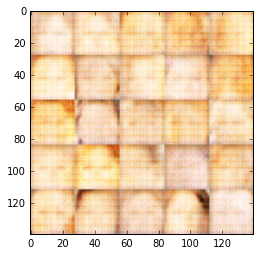

Epoch 0/1	 Discirminator Loss 1.2760	 Generator Loss 0.7052
Epoch 0/1	 Discirminator Loss 1.3818	 Generator Loss 0.7876
Epoch 0/1	 Discirminator Loss 1.3261	 Generator Loss 0.9153
Epoch 0/1	 Discirminator Loss 1.3669	 Generator Loss 0.7344
Epoch 0/1	 Discirminator Loss 1.2923	 Generator Loss 0.8699
Epoch 0/1	 Discirminator Loss 1.3754	 Generator Loss 0.8107
Epoch 0/1	 Discirminator Loss 1.2134	 Generator Loss 0.6773
Epoch 0/1	 Discirminator Loss 1.3908	 Generator Loss 0.7127
Epoch 0/1	 Discirminator Loss 1.2398	 Generator Loss 0.7689
Epoch 0/1	 Discirminator Loss 1.3834	 Generator Loss 0.5546


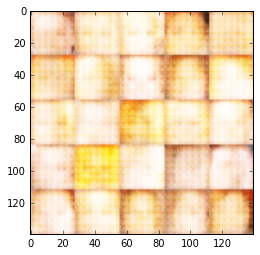

Epoch 0/1	 Discirminator Loss 1.3017	 Generator Loss 0.7775
Epoch 0/1	 Discirminator Loss 1.2784	 Generator Loss 0.9169
Epoch 0/1	 Discirminator Loss 1.3001	 Generator Loss 0.8024
Epoch 0/1	 Discirminator Loss 1.3753	 Generator Loss 0.8950
Epoch 0/1	 Discirminator Loss 1.3129	 Generator Loss 0.8232
Epoch 0/1	 Discirminator Loss 1.3992	 Generator Loss 0.9974
Epoch 0/1	 Discirminator Loss 1.0728	 Generator Loss 0.7775
Epoch 0/1	 Discirminator Loss 1.3804	 Generator Loss 0.8487
Epoch 0/1	 Discirminator Loss 1.3064	 Generator Loss 0.7468
Epoch 0/1	 Discirminator Loss 1.2330	 Generator Loss 0.8897


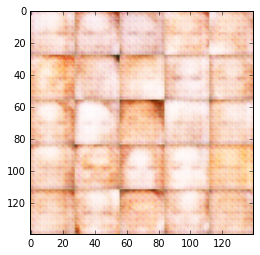

Epoch 0/1	 Discirminator Loss 1.2060	 Generator Loss 0.6590
Epoch 0/1	 Discirminator Loss 1.3161	 Generator Loss 0.7536
Epoch 0/1	 Discirminator Loss 1.2521	 Generator Loss 0.6842
Epoch 0/1	 Discirminator Loss 1.2168	 Generator Loss 0.8415
Epoch 0/1	 Discirminator Loss 1.3339	 Generator Loss 0.8036
Epoch 0/1	 Discirminator Loss 1.3379	 Generator Loss 0.8471
Epoch 0/1	 Discirminator Loss 1.3423	 Generator Loss 0.7269
Epoch 0/1	 Discirminator Loss 1.2925	 Generator Loss 0.8004
Epoch 0/1	 Discirminator Loss 1.3441	 Generator Loss 0.9150
Epoch 0/1	 Discirminator Loss 1.3048	 Generator Loss 0.8909


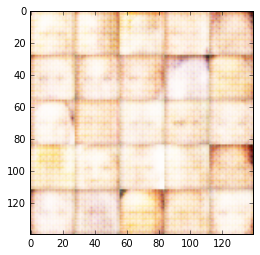

Epoch 0/1	 Discirminator Loss 1.2264	 Generator Loss 0.6557
Epoch 0/1	 Discirminator Loss 1.2863	 Generator Loss 0.6720
Epoch 0/1	 Discirminator Loss 1.2922	 Generator Loss 0.7523
Epoch 0/1	 Discirminator Loss 1.3289	 Generator Loss 0.8266
Epoch 0/1	 Discirminator Loss 1.3861	 Generator Loss 0.9406
Epoch 0/1	 Discirminator Loss 1.2930	 Generator Loss 0.7453
Epoch 0/1	 Discirminator Loss 1.1892	 Generator Loss 0.7057
Epoch 0/1	 Discirminator Loss 1.3991	 Generator Loss 0.6574
Epoch 0/1	 Discirminator Loss 1.2577	 Generator Loss 0.8021
Epoch 0/1	 Discirminator Loss 1.3159	 Generator Loss 0.8371


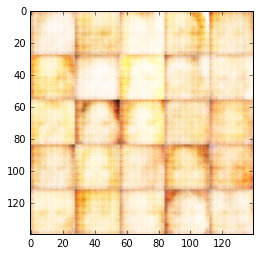

Epoch 0/1	 Discirminator Loss 1.3449	 Generator Loss 0.8126
Epoch 0/1	 Discirminator Loss 1.5788	 Generator Loss 0.4041
Epoch 0/1	 Discirminator Loss 1.4433	 Generator Loss 0.9280
Epoch 0/1	 Discirminator Loss 1.3202	 Generator Loss 0.8145
Epoch 0/1	 Discirminator Loss 1.3298	 Generator Loss 0.8213
Epoch 0/1	 Discirminator Loss 1.3056	 Generator Loss 0.6827
Epoch 0/1	 Discirminator Loss 1.3453	 Generator Loss 0.7783
Epoch 0/1	 Discirminator Loss 1.3346	 Generator Loss 0.9597
Epoch 0/1	 Discirminator Loss 1.2928	 Generator Loss 0.7563
Epoch 0/1	 Discirminator Loss 1.4025	 Generator Loss 0.8672


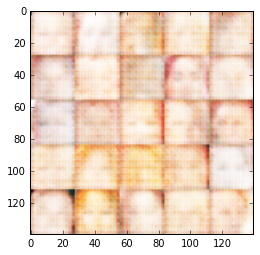

Epoch 0/1	 Discirminator Loss 1.3262	 Generator Loss 0.7284
Epoch 0/1	 Discirminator Loss 1.3333	 Generator Loss 0.7419
Epoch 0/1	 Discirminator Loss 1.3502	 Generator Loss 0.7528
Epoch 0/1	 Discirminator Loss 1.3354	 Generator Loss 0.8653
Epoch 0/1	 Discirminator Loss 1.3550	 Generator Loss 0.7300
Epoch 0/1	 Discirminator Loss 1.3522	 Generator Loss 0.8355
Epoch 0/1	 Discirminator Loss 1.3817	 Generator Loss 0.9538
Epoch 0/1	 Discirminator Loss 1.3227	 Generator Loss 0.8361
Epoch 0/1	 Discirminator Loss 1.3374	 Generator Loss 0.7646
Epoch 0/1	 Discirminator Loss 1.3298	 Generator Loss 0.8583


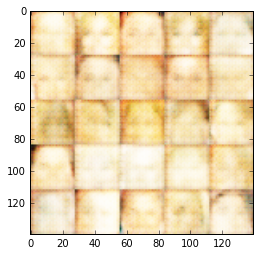

Epoch 0/1	 Discirminator Loss 1.3124	 Generator Loss 0.7687
Epoch 0/1	 Discirminator Loss 1.3041	 Generator Loss 0.7506
Epoch 0/1	 Discirminator Loss 1.3193	 Generator Loss 0.8375
Epoch 0/1	 Discirminator Loss 1.3151	 Generator Loss 0.8535
Epoch 0/1	 Discirminator Loss 1.3273	 Generator Loss 0.9052
Epoch 0/1	 Discirminator Loss 1.3198	 Generator Loss 0.7284
Epoch 0/1	 Discirminator Loss 1.3743	 Generator Loss 0.8954
Epoch 0/1	 Discirminator Loss 1.3034	 Generator Loss 0.7304
Epoch 0/1	 Discirminator Loss 1.4851	 Generator Loss 1.2378
Epoch 0/1	 Discirminator Loss 1.3262	 Generator Loss 0.8494


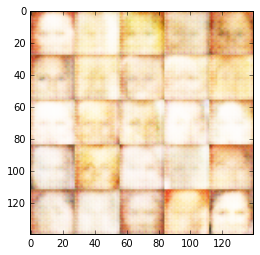

Epoch 0/1	 Discirminator Loss 1.2950	 Generator Loss 0.7686
Epoch 0/1	 Discirminator Loss 1.3373	 Generator Loss 0.9222
Epoch 0/1	 Discirminator Loss 1.3502	 Generator Loss 0.7477
Epoch 0/1	 Discirminator Loss 1.3684	 Generator Loss 0.8400
Epoch 0/1	 Discirminator Loss 1.3703	 Generator Loss 0.7247
Epoch 0/1	 Discirminator Loss 1.3299	 Generator Loss 0.8141
Epoch 0/1	 Discirminator Loss 1.3947	 Generator Loss 0.7329
Epoch 0/1	 Discirminator Loss 1.3379	 Generator Loss 0.7709
Epoch 0/1	 Discirminator Loss 1.3748	 Generator Loss 0.7530
Epoch 0/1	 Discirminator Loss 1.3399	 Generator Loss 0.7265


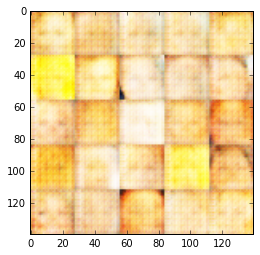

Epoch 0/1	 Discirminator Loss 1.3606	 Generator Loss 0.6507
Epoch 0/1	 Discirminator Loss 1.3270	 Generator Loss 0.8070
Epoch 0/1	 Discirminator Loss 1.2677	 Generator Loss 0.6899
Epoch 0/1	 Discirminator Loss 1.3058	 Generator Loss 0.7544
Epoch 0/1	 Discirminator Loss 1.3297	 Generator Loss 0.7856
Epoch 0/1	 Discirminator Loss 1.3134	 Generator Loss 1.0072
Epoch 0/1	 Discirminator Loss 1.4189	 Generator Loss 0.6735
Epoch 0/1	 Discirminator Loss 1.3185	 Generator Loss 0.8084
Epoch 0/1	 Discirminator Loss 1.3198	 Generator Loss 0.7433
Epoch 0/1	 Discirminator Loss 1.3490	 Generator Loss 0.8701


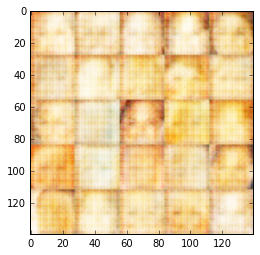

Epoch 0/1	 Discirminator Loss 1.3676	 Generator Loss 0.7766
Epoch 0/1	 Discirminator Loss 1.3910	 Generator Loss 0.8562
Epoch 0/1	 Discirminator Loss 1.2459	 Generator Loss 0.7084
Epoch 0/1	 Discirminator Loss 1.3261	 Generator Loss 0.9037
Epoch 0/1	 Discirminator Loss 1.3148	 Generator Loss 0.9430
Epoch 0/1	 Discirminator Loss 1.3509	 Generator Loss 0.7825


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.2
alpha = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode,alpha)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.